In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import astropy
import pickle as p
import glob

In [3]:
plt.rcParams['font.size']=20
plt.rcParams['font.family']='Sans Serif'
plt.rcParams['lines.linewidth']=2.5
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.minor.size']=5
plt.rcParams['xtick.major.width']=2
plt.rcParams['xtick.minor.width']=1
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.minor.size']=5
plt.rcParams['ytick.major.width']=2
plt.rcParams['ytick.minor.width']=1
plt.rcParams['ytick.direction']='in'

In [4]:
problem_id='MHD_4pc_new'

In [5]:
zprof_fnames=[]
for ph in ['phase3','phase4','phase5','whole']:
    zprof_fnames.append('/Users/ckim/Research/TIGRESS/{}/zprof_merged/{}.{}.zprof.nc'.format(problem_id,problem_id,ph))
zprof_fnames

['/Users/ckim/Research/TIGRESS/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase3.zprof.nc',
 '/Users/ckim/Research/TIGRESS/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase4.zprof.nc',
 '/Users/ckim/Research/TIGRESS/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase5.zprof.nc',
 '/Users/ckim/Research/TIGRESS/MHD_4pc_new/zprof_merged/MHD_4pc_new.whole.zprof.nc']

In [6]:
data=xr.open_dataarray(zprof_fnames[0])
data.load()
data.close()

import astropy.constants as c
import astropy.units as u
G = c.G.cgs.value
Msun = c.M_sun.cgs.value
pc = c.pc.cgs.value
pi = np.pi
m_unit = 1.4271*c.m_p.cgs.value*pc**3
l_unit = pc
v_unit = 1.e5
t_unit = l_unit/v_unit
G_code = (G/l_unit**3)*m_unit*t_unit**2
rho_unit = m_unit/l_unit**3

p_unit = rho_unit*v_unit**2#m_unit * (1./l_unit) / t_unit/ t_unit
deltaz = data.zaxis.data[1]-data.zaxis.data[0]
kb = c.k_B.cgs.value
print(rho_unit, p_unit, pc, deltaz, kb)

2.3869987106358e-24 2.3869987106358e-14 3.085677581467192e+18 4.0 1.38064852e-16


In [7]:
data=[]
for zf in zprof_fnames:
    with xr.open_dataarray(zf) as zp:
        zp.load()
        data.append(zp)

In [8]:
phase=['warm','intermediate','hot','total']
color = ['green','orange','red','black']
Plabel =[r'$\langle P_{th}\rangle$',r'$\langle P_{\rm turb,z}\rangle$',r'$\langle \Pi_{\rm mag}\rangle$'] 
linestyle = ['-','--',':','-.']

In [9]:
to_Myr=(c.pc/(u.km/u.s)).to('Myr').value 
t1=200/to_Myr
t2=500/to_Myr

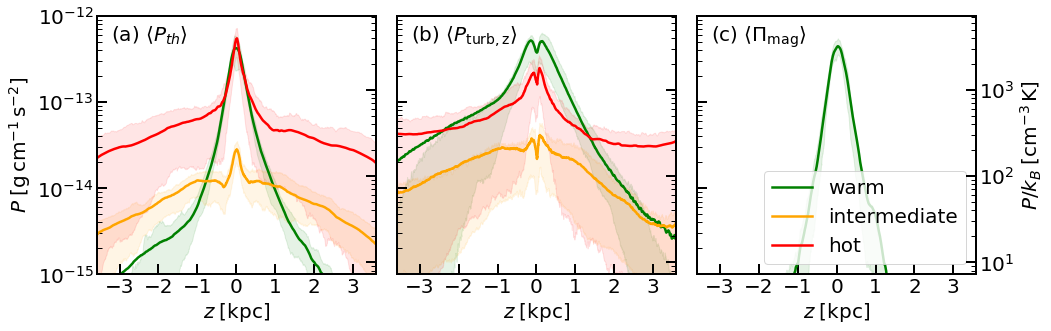

In [10]:
from matplotlib.ticker import MultipleLocator

f, ax = plt.subplots(1, 3, figsize=(15,5))

axi = []
for j in range(3): axi = np.append(axi, ax[j].twinx())    
    

for i in range(3):
    data_=data[i]
    zaxis=data_.zaxis
    tot_area=1024*1024
    Pth=data_.sel(fields=b'P',taxis=slice(t1,t2))
    Pturb=2.0*data_.sel(fields=b'Ek3',taxis=slice(t1,t2))
    Pmag=data_.sel(fields=[b'PB1',b'PB2',b'PB3']).sum(dim='fields')-data_.sel(fields=[b'PB3']).sum(dim='fields')*2.0
    Pmag=Pmag.sel(taxis=slice(t1,t2))
    for j,P in zip(range(3),[Pth,Pturb,Pmag]):
        #print(P.shape)
        qmean=np.nanmean(P*p_unit/tot_area,axis=1)
        q1,q2,q3=np.percentile(P*p_unit/tot_area,[25,50,75],axis=1)
        ax[j].plot(zaxis/1.e3,qmean,label=phase[i], color=color[i])
        #ax[j].plot(zaxis/1.e3,q2,label=label[i], color=color[i],linewidth=2.5,ls='--')
        ax[j].fill_between(zaxis/1.e3,q1,q3,color=color[i],alpha=0.1)
plt.setp([ax,axi],'yscale','log')
plt.setp(ax,'xticks',np.arange(-3.,3.5,1.))
plt.setp(ax,'ylim',(1.e-15,1.e-12))
plt.setp(axi,'ylim',(1.e-15/kb, 1.e-12/kb))
plt.setp(ax,'xlim',(-3.584,3.584))
plt.setp(ax,'xlabel',r'$z\;[{\rm kpc}]$')

plt.setp([ax_.get_yticklabels() for ax_ in ax[1:]],visible=False)
plt.setp([ax_.get_yticklabels() for ax_ in axi[:-1]],visible=False)


ax[0].set_ylabel(r'$P\;[{\rm g\,cm^{-1}\,s^{-2}}]$')
axi[2].set_ylabel(r'$P/k_B\;[{\rm cm^{-3}\,K}]$')
ax[2].legend(loc='lower right')

for ax_,alab_,i in zip(ax,'abc',range(3)):
    ax_.text(0.05,0.9,r'({}) {}'.format(alab_,Plabel[i]),transform=ax_.transAxes)
plt.tight_layout()

plt.savefig("mean_profiles.pdf",bbox_inches='tight',dpi=150)

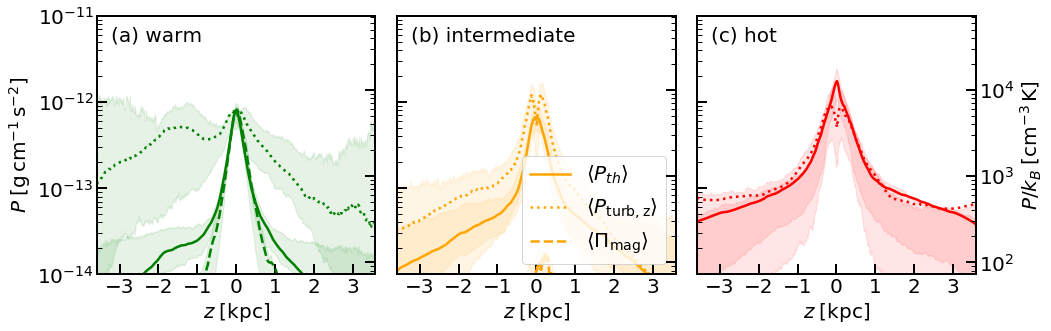

In [11]:
from matplotlib.ticker import MultipleLocator
linestyle = ['-',':','--']

f, ax = plt.subplots(1, 3, figsize=(15,5))

axi = []
for j in range(3): axi = np.append(axi, ax[j].twinx())    
    

for i in range(3):    
    data_=data[i]
    zaxis=data_.zaxis
    area=data_.sel(fields=b'A',taxis=slice(t1,t2))
    Pth=data_.sel(fields=b'P',taxis=slice(t1,t2))
    Pturb=2.0*data_.sel(fields=b'Ek3',taxis=slice(t1,t2))
    Pmag=data_.sel(fields=[b'PB1',b'PB2',b'PB3']).sum(dim='fields')-data_.sel(fields=[b'PB3']).sum(dim='fields')*2.0
    Pmag=Pmag.sel(taxis=slice(t1,t2))
    for j,P in zip(range(3),[Pth,Pturb,Pmag]):
        #print(P.shape)
        qmean=np.nanmean(P*p_unit/area,axis=1)
        qmean=np.nanmean(P*p_unit,axis=1)/area.mean(axis=1)
        q1,q2,q3=np.nanpercentile(P*p_unit/area,[25,50,75],axis=1)
        ax[i].plot(zaxis/1.e3,qmean,label=Plabel[j], ls=linestyle[j], color=color[i])
        #ax[i].plot(zaxis/1.e3,q2,label=label[i], ls=linestyle[j], color=color[i],linewidth=1)
        ax[i].fill_between(zaxis/1.e3,q1,q3,color=color[i],alpha=0.1)


plt.setp([ax,axi],'yscale','log')
plt.setp(ax,'xticks',np.arange(-3.,3.5,1.))
plt.setp(ax,'ylim',(1.e-14,1.e-11))
plt.setp(axi,'ylim',(1.e-14/kb, 1.e-11/kb))
plt.setp(ax,'xlim',(-3.584,3.584))
plt.setp(ax,'xlabel',r'$z\;[{\rm kpc}]$')

plt.setp([ax_.get_yticklabels() for ax_ in ax[1:]],visible=False)
plt.setp([ax_.get_yticklabels() for ax_ in axi[:-1]],visible=False)

ax[0].set_ylabel(r'$P\;[{\rm g\,cm^{-1}\,s^{-2}}]$')
axi[2].set_ylabel(r'$P/k_B\;[{\rm cm^{-3}\,K}]$')
ax[1].legend(loc='lower right')


for ax_,alab_,i in zip(ax,'abc',range(3)):
    ax_.text(0.05,0.9,r'({}) {}'.format(alab_,phase[i]),transform=ax_.transAxes)
plt.tight_layout()

plt.savefig("../figures/typical_profiles.pdf",bbox_inches='tight',dpi=150)

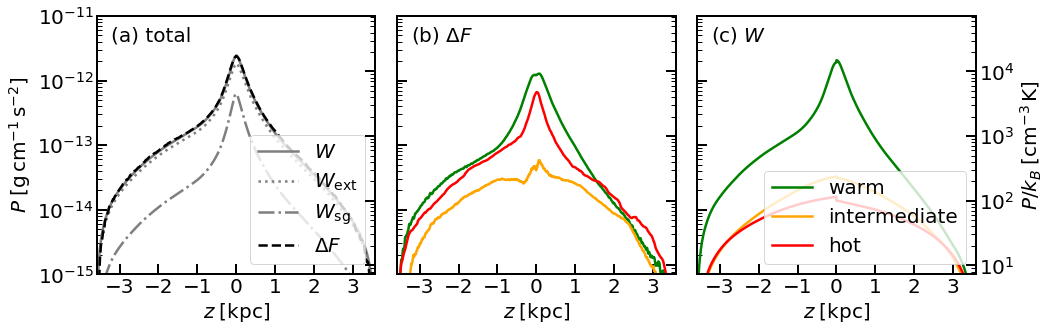

In [12]:
from matplotlib.ticker import MultipleLocator

def get_flux_weight(data_,t1,t2):
    zaxis=data_.zaxis
    hNz=int(len(zaxis)/2)
    area=1024*1024
    Pth=data_.sel(fields=b'P',taxis=slice(t1,t2))
    Pturb=2.0*data_.sel(fields=b'Ek3',taxis=slice(t1,t2))
    Pmag=data_.sel(fields=[b'PB1',b'PB2',b'PB3']).sum(dim='fields')-data_.sel(fields=[b'PB3']).sum(dim='fields')*2.0
    Pmag=Pmag.sel(taxis=slice(t1,t2))
    totFlux=np.nanmean((Pth+Pturb+Pmag)*p_unit/area,axis=1)
    totFlux[hNz:] -= totFlux[-1]
    totFlux[:hNz] -= totFlux[0]
    dWext_u=data_.sel(fields=b'dWext',taxis=slice(t1,t2)).mean(dim='taxis').sel(zaxis=slice(0,1.e4))[::-1]
    dWext_l=-data_.sel(fields=b'dWext',taxis=slice(t1,t2)).mean(dim='taxis').sel(zaxis=slice(-1.e4,0))
    Wext=xr.concat([dWext_l.cumsum(),dWext_u.cumsum()[::-1]],dim='zaxis')*deltaz*p_unit/area
    dWsg_u=data_.sel(fields=b'dWsg',taxis=slice(t1,t2)).mean(dim='taxis').sel(zaxis=slice(0,1.e4))[::-1]
    dWsg_l=-data_.sel(fields=b'dWsg',taxis=slice(t1,t2)).mean(dim='taxis').sel(zaxis=slice(-1.e4,0))
    Wsg=xr.concat([dWsg_l.cumsum(),dWsg_u.cumsum()[::-1]],dim='zaxis')*deltaz*p_unit/area
    Weight=Wext+Wsg
    return totFlux,Weight,Wext,Wsg

color = ['green','orange','red','black']


f, ax = plt.subplots(1,3, figsize=(15,5))
ax=ax.flatten()
axi = []
for j in range(3): axi = np.append(axi, ax[j].twinx())    

# for total gas
ax_= ax[0]
data_ = data[3]
F,W,We,Ws = get_flux_weight(data_,t1,t2)

ax_.plot(data_.zaxis/1.e3,W,ls='-',color='C7',label=r'$W$')
ax_.plot(data_.zaxis/1.e3,We,ls=':',color='C7',label=r'$W_{\rm ext}$')
ax_.plot(data_.zaxis/1.e3,Ws,ls='-.',color='C7',label=r'$W_{\rm sg}$')
ax_.plot(data_.zaxis/1.e3,F,ls='--',color='k',label=r'$\Delta F$')

ax_= ax[1]
for i in [0,1,2]:
    data_ = data[i]
    F,W,We,Ws = get_flux_weight(data_,t1,t2)
    ax_.plot(data_.zaxis/1.e3,F,ls='-',color=color[i])
    
ax_= ax[2]
for i in [0,1,2]:
    data_ = data[i]
    F,W,We,Ws = get_flux_weight(data_,t1,t2)
    ax_.plot(data_.zaxis/1.e3,W,ls='-',color=color[i],label=phase[i])
#ax_.plot(data_.zaxis/1.e3,W,ls='-',color='C4')
#ax_.plot(data_.zaxis/1.e3,We,ls='--',color='C4')
#ax_.plot(data_.zaxis/1.e3,Ws,ls=':',color='C4')
# for i,ax_ in zip([0,1,2],ax):
#     data_=data[i]
#     for j,P in zip(range(4),[totFlux,Weight,Wext,Wsg]):
#         #print(P.shape)
        
#         ax_.plot(zaxis/1.e3,P, ls=linestyle[j], color=color[i],linewidth=2.5)

plt.setp([ax,axi],'yscale','log')
plt.setp(ax,'xticks',np.arange(-3.,3.5,1.))
plt.setp(ax,'ylim',(1.e-15,1.e-11))
plt.setp(axi,'ylim',(1.e-15/kb, 1.e-11/kb))
plt.setp(ax,'xlim',(-3.584,3.584))
plt.setp(ax,'xlabel',r'$z\;[{\rm kpc}]$')

plt.setp([ax_.get_yticklabels() for ax_ in ax[1:]],visible=False)
plt.setp([ax_.get_yticklabels() for ax_ in axi[:-1]],visible=False)

ax[0].set_ylabel(r'$P\;[{\rm g\,cm^{-1}\,s^{-2}}]$')
axi[2].set_ylabel(r'$P/k_B\;[{\rm cm^{-3}\,K}]$')
ax[0].legend(loc='lower right')
ax[2].legend(loc='lower right')

for ax_,plabel in zip(ax,[r'(a) total',r'(b) $\Delta F$',r'(c) $W$']):
    ax_.text(0.05,0.9,plabel,transform=ax_.transAxes)
plt.tight_layout()

plt.savefig("../figures/vertical_equilibrium.pdf",bbox_inches='tight',dpi=150)

[0.01, 100.0, 0.01, 100.0, 0.01, 100.0]

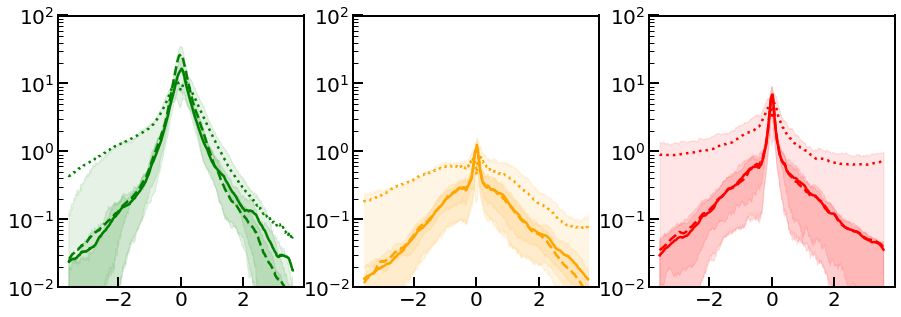

In [210]:
f, ax = plt.subplots(1,3, figsize=(15,5))

for i in range(3):    
    data_=data[i]
    zaxis=data_.zaxis
    area=1024*1024.
    Ek1=data_.sel(fields=b'Ek1',taxis=slice(t1,t2))
    Ek2=data_.sel(fields=b'Ek2',taxis=slice(t1,t2))
    Ek3=data_.sel(fields=b'Ek3',taxis=slice(t1,t2))
    
    for j,P in zip(range(3),[Ek1,Ek2,Ek3]):
        #print(P.shape)
        qmean=np.nanmean(P/area,axis=1)
        q1,q2,q3=np.nanpercentile(P/area,[25,50,75],axis=1)
        ax[i].plot(zaxis/1.e3,qmean,label=Plabel[j], ls=linestyle[j], color=color[i])
        #ax[i].plot(zaxis/1.e3,q2,label=label[i], ls=linestyle[j], color=color[i],linewidth=1)
        ax[i].fill_between(zaxis/1.e3,q1,q3,color=color[i],alpha=0.1)
plt.setp(ax,'yscale','log')
plt.setp(ax,'ylim',(1.e-2,1.e2))

[-0.05, 0.05, -0.05, 0.05, -0.05, 0.05]

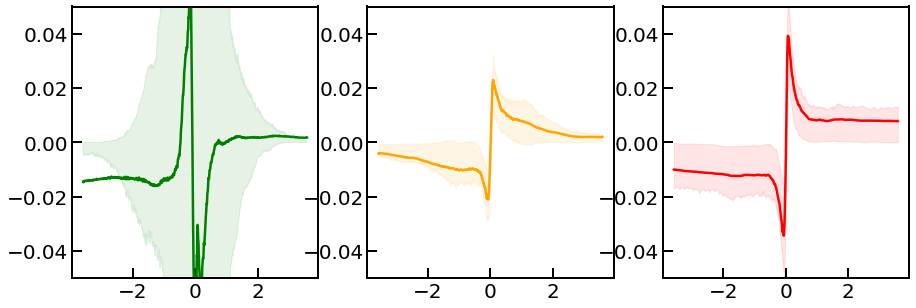

In [214]:
f, ax = plt.subplots(1,3, figsize=(15,5))

for i in range(3):    
    data_=data[i]
    zaxis=data_.zaxis
    area=1024*1024.
    d=data_.sel(fields=b'M3',taxis=slice(t1,t2))
    #Ek2=data_.sel(fields=b'Ek2',taxis=slice(t1,t2))
    #Ek3=data_.sel(fields=b'Ek3',taxis=slice(t1,t2))
    
    for j,P in zip(range(1),[d]):
        #print(P.shape)
        qmean=np.nanmean(P/area,axis=1)
        q1,q2,q3=np.nanpercentile(P/area,[25,50,75],axis=1)
        ax[i].plot(zaxis/1.e3,qmean,label=Plabel[j], ls=linestyle[j], color=color[i])
        #ax[i].plot(zaxis/1.e3,q2,label=label[i], ls=linestyle[j], color=color[i],linewidth=1)
        ax[i].fill_between(zaxis/1.e3,q1,q3,color=color[i],alpha=0.1)
#plt.setp(ax,'yscale','log')
plt.setp(ax,'ylim',(-5.e-2,5.e-2))

[None, None, None]

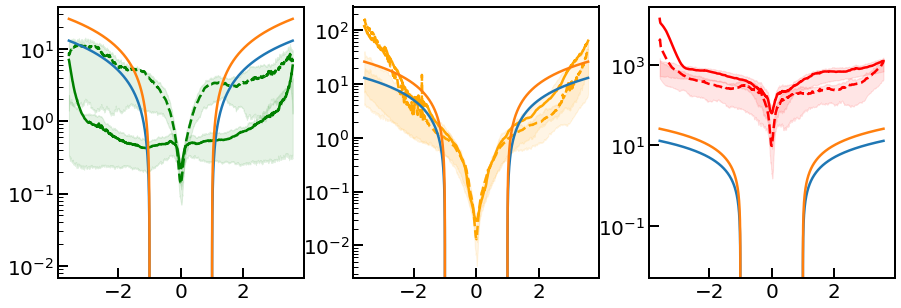

In [244]:
f, ax = plt.subplots(1,3, figsize=(15,5))


for i in range(3):    
    data_=data[i]
    zaxis=data_.zaxis
    area=1024*1024.
    cool=data_.sel(fields=b'cool',taxis=slice(t1,t2))
    heat=data_.sel(fields=b'heat',taxis=slice(t1,t2))
    P=data_.sel(fields=b'P',taxis=slice(t1,t2))
    Pturb=2.0*data_.sel(fields=b'Ek3',taxis=slice(t1,t2))
    tcool=1.5*P/cool
    tcool_turb=Pturb/cool
    for j,P in zip(range(2),[tcool,tcool_turb]):
        qmean=np.nanmean(P,axis=1)
        q1,q2,q3=np.nanpercentile(P,[25,50,75],axis=1)
        ax[i].plot(zaxis/1.e3,qmean,label=Plabel[j], ls=linestyle[j], color=color[i])
        ax[i].fill_between(zaxis/1.e3,q1,q3,color=color[i],alpha=0.1)
    ax[i].plot(zaxis/1.e3,(np.abs(zaxis)-1000.)/200.)
    ax[i].plot(zaxis/1.e3,(np.abs(zaxis)-1000.)/100.)
plt.setp(ax,'yscale','log')
#plt.setp(ax,'ylim',(1.e-4,1.e4))

In [245]:
(3.5-1)*1.e3/200.

12.5

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


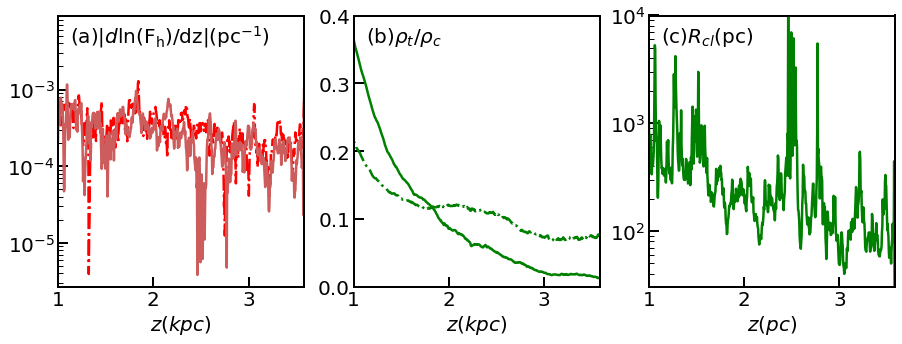

In [14]:

dlnFh = np.diff(np.log(Flux[2,:]))
dz  = np.diff(zaxis)
n0 = int ( 3584./deltaz)
Rcl = 0.75 * (Density[0,:-1]/density[0,:-1])/ abs(dlnFh/dz)


from matplotlib.ticker import MultipleLocator

#color = ['green', 'orange', 'red','black']
#label =[r'warm','intermediate', r'hot',r'all'] 

f, ax = plt.subplots(1, 3, figsize=(15,5))
for i in range(3):
    ax[i].set_xlim(1.,3.584)
    ax[i].set_xticks(np.arange(1.0,3.584, 1.))

ax[0].plot(abs(zaxis[:n0])/1.e3,abs(dlnFh[:n0]/dz[:n0]), ls='-.',linewidth=2.5, label='z<0', color='red')
ax[0].plot(zaxis[n0:]/1.e3,abs(dlnFh[n0-1:]/dz[n0-1:]),ls='-', linewidth=2.5, label = 'z>0', color='indianred')
ax[0].set_yscale('log')
ax[0].set_xlabel("$z(kpc)$")

ax[1].plot(abs(zaxis[:n0])/1.e3,Density[0,:n0]/density[0,:n0], ls='-.',linewidth=2.5, color='green')
ax[1].plot(zaxis[n0:]/1.e3,Density[0,n0:]/density[0,n0:],ls='-',linewidth=2.5, color='green')
ax[1].legend()
ax[1].set_xlabel("$z(kpc)$")
ax[1].set_yticks(np.arange(0.0, 0.5, 0.1))
leg = ax[1].legend()
ax[1].set_ylim(0,0.4)
leg.get_frame().set_linewidth(0.0)


ax[2].plot(zaxis[n0:]/1.e3,Rcl[n0-1:],ls='-',linewidth=2.5, color='green')
ax[2].set_yscale('log')
ax[2].legend()
ax[2].set_xlabel("$z(pc)$")
ax[2].set_ylim(30.,1.e4)
leg = ax[2].legend()

leg.get_frame().set_linewidth(0.0)

for ax_,plabel in zip(ax,[r'(a)|$d\rm{ln}(F_{h})/dz|$(pc$^{-1}$)',r'(b)$\rho_t/\rho_c$', r'(c)$R_{cl}$(pc)']):
    ax_.text(0.05,0.9,plabel,transform=ax_.transAxes)


plt.savefig("../figures/dlnFh_volfrac_rcl.pdf", bbox='tight',dpi=150)

/Users/aditiv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/aditiv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


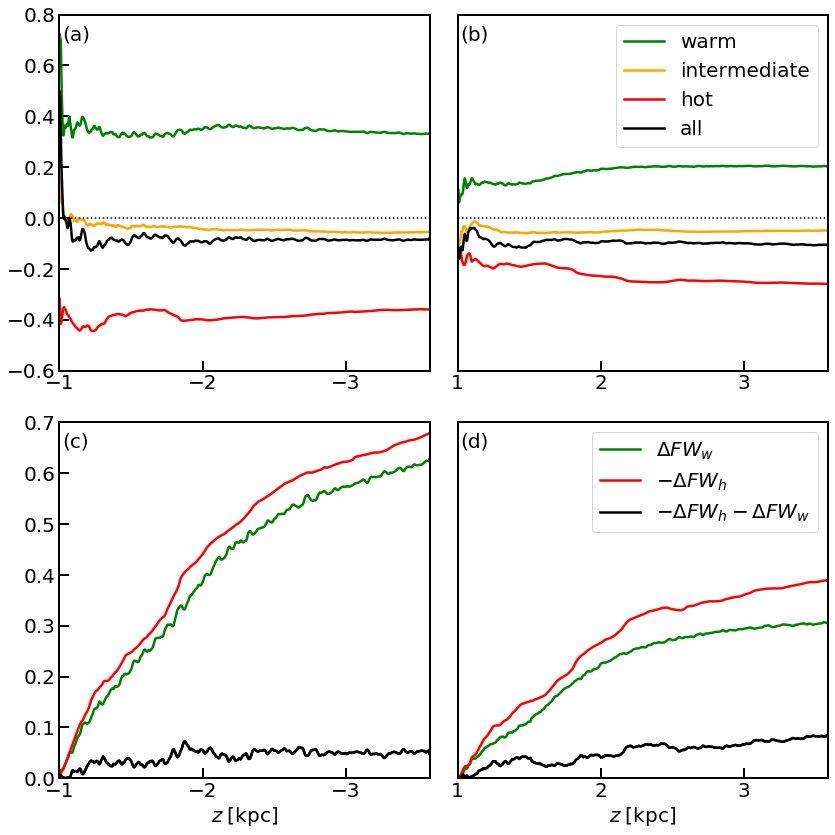

In [16]:
from matplotlib.ticker import MultipleLocator

color = ['green', 'orange', 'red','black']
label =[r'warm','intermediate', r'hot',r'all'] 
label1 =[r'$\Delta FW_{w}$','', r'$-\Delta FW_{h}$',r'$-\Delta FW_{h}-\Delta FW_{w}$']
label2=['', '', r'$-\Delta FW_{h}-\Delta FW_{w}$','','']


f, ax = plt.subplots(2, 2, figsize=(12,12))
DelFW = (Del_mom+Del_w)
DelHW = (-DelFW[2,:]-DelFW[0,:])
   
for i in [0,2]:    
    ax[1,0].plot(zaxis/1.e3,abs(DelFW[i,:])/1.e-13,label='', color=color[i],linewidth=2.5) 
    ax[1,1].plot(zaxis/1.e3,abs(DelFW[i,:])/1.e-13,label=label1[i], color=color[i],linewidth=2.5) 
    ax[1,0].plot(zaxis/1.e3,abs(DelHW[:])/1.e-13,label='', color='black',linewidth=2.5) 
    ax[1,1].plot(zaxis/1.e3,abs(DelHW[:])/1.e-13,label=label2[i], color='black',linewidth=2.5) 

for i in range(4):    
    ax[0,0].plot(zaxis/1.e3,(DelFW[i,:])/Del_w[3,:],label=label[i], color=color[i],linewidth=2.5) 
    ax[0,1].plot(zaxis/1.e3,(DelFW[i,:])/Del_w[3,:],label=label[i], color=color[i],linewidth=2.5) 
    

plt.setp(ax[0,1],'xlim',(1.0,3.584))
plt.setp(ax[0,1],'xticks',np.arange(1.,3.584,1.))
plt.setp([ax[1,:],axi],'yscale','linear')
plt.setp(ax[1,:],'ylim',(0.0,0.7))
plt.setp(axi,'ylim',(0.0/kb, 0.7e-13/kb))     
plt.setp(ax[1,0],'xlim',(-1.0,-3.584))
plt.setp(ax[1,0],'xticks',np.arange(-1.,-3.584,-1.))  
plt.setp(ax[1,1],'xlim',(1.0,3.584))
plt.setp(ax[1,1],'xticks',np.arange(1.,3.584,1.))  
plt.setp(ax[0,0],'xlim',(-1.0,-3.584))
plt.setp(ax[0,0],'xticks',np.arange(-1.,-3.584,-1.))
plt.setp([ax],'yscale','linear')
plt.setp(ax[0,:],'ylim',(-0.6,0.8))
ax[1,1].legend()
ax[0,1].legend()
# axi[0].yaxis.set_visible(False)
ax[1,1].yaxis.set_visible(False)
ax[0,1].yaxis.set_visible(False)
ax[1,0].text(-1.02,0.65, r"(c)")
ax[1,1].text(1.02,0.65, r"(d)")
ax[0,0].text(-1.02,0.7, r"(a)")
ax[0,1].text(1.02,0.7, r"(b)")
for j in range(2):
    ax[0,j].axhline(color='black',ls=':')
for ax in ax[1,:]:plt.setp(ax,'xlabel',r'$z\;[{\rm kpc}]$')

plt.tight_layout()
plt.savefig("../figures/PSTA_fluxratio_v2.pdf",bbox_inches='tight',dpi=150)